In [1]:
import sys

sys.path.append('../')

from model_v2 import  *
from data import *
import os
import keras
import cv2
from keras.callbacks import TensorBoard
import tensorflow as tf
import keras.backend.tensorflow_backend as K
import matplotlib.pyplot as plt

from utils import helpers

Using TensorFlow backend.


In [2]:
train_path = "../640x400_small"
image_folder = "train"
label_folder = "trainannot"
valid_path =  "../640x400_small"
valid_image_folder ="val"
valid_label_folder = "valannot"
test_path = '../640x400_small/test/'
log_filepath = '../log'
weights_path = '../model/adadelta_011439.hdf5'
flag_multi_class = True
num_classes = 4

dp = data_preprocess(
    train_path=train_path,image_folder=image_folder,label_folder=label_folder,
    valid_path=valid_path,valid_image_folder=valid_image_folder,valid_label_folder=valid_label_folder,
    flag_multi_class=flag_multi_class, num_classes=num_classes, 
    test_path=test_path, img_rows=640, img_cols=400, csv_name='class_dict.csv'
)

# train your own model
train_data = dp.trainGenerator(batch_size=2)
valid_data = dp.validLoad(batch_size=2)
test_data = dp.testGenerator()

model = unet(pretrained_weights=weights_path, num_class=4, input_size=(640, 400, 3))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 640, 400, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 640, 400, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 640, 400, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxP

In [3]:
# img = next(dp.testGenerator())
img, lb = next(dp.trainGenerator(1))
img.shape

Found 421 images belonging to 1 classes.
Found 421 images belonging to 1 classes.


(1, 640, 400, 3)

## Imagen a predecir

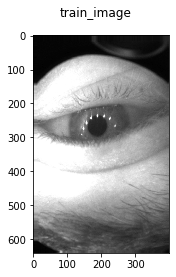

In [4]:
fig = plt.figure()
fig.suptitle('train_image')
plt.imshow(img[0])
plt.show()

## Mascaras correspondientes One-Hot

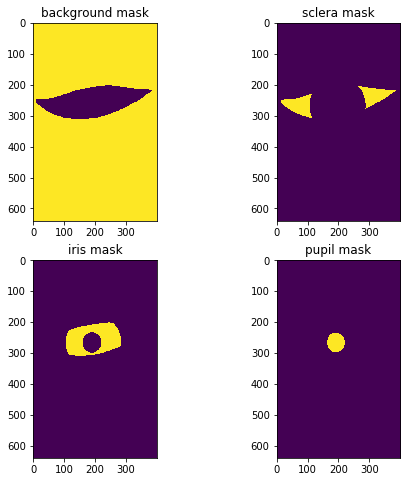

In [5]:
fig = plt.figure(figsize=(8, 8))

sub1 = plt.subplot(2, 2, 1)
sub1.set_title('background mask')
sub1.imshow((lb[0, :, :, 0]*255).astype(np.uint8))

sub2 = plt.subplot(2, 2, 2)
sub2.set_title('sclera mask')
sub2.imshow((lb[0, :, :, 1]*255).astype(np.uint8))

sub3 = plt.subplot(2, 2, 3)
sub3.set_title('iris mask')
sub3.imshow((lb[0, :, :, 2]*255).astype(np.uint8))

sub4 = plt.subplot(2, 2, 4)
sub4.set_title('pupil mask')
sub4.imshow((lb[0, :, :, 3]*255).astype(np.uint8))

plt.show()

In [6]:
np.unique((lb[0, :, :, :]*255).astype(np.uint8))

array([  0, 255], dtype=uint8)

## Reverse One-Hot & Colour Code Segmentation

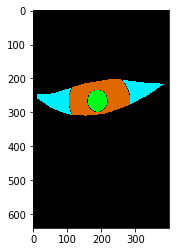

In [7]:
rev_oh = helpers.reverse_one_hot(lb[0])
lb_rev_oh_ccs = helpers.colour_code_segmentation(rev_oh, dp.label_values)
plt.imshow(lb_rev_oh_ccs)
plt.show()

In [8]:
np.unique(img)

array([0.00392157, 0.00393541, 0.00395589, ..., 0.9999989 , 0.9999995 ,
       1.        ], dtype=float32)

In [9]:
img.shape

(1, 640, 400, 3)

In [10]:
pred = model.predict(img)

In [11]:
pred.shape

(1, 640, 400, 4)

In [12]:
np.unique(pred[0, :, :, :]) # escala de grises

array([3.3593018e-13, 3.3755724e-13, 3.4648030e-13, ..., 9.9986017e-01,
       9.9986136e-01, 9.9986184e-01], dtype=float32)

## Mapa Semántico no procesado

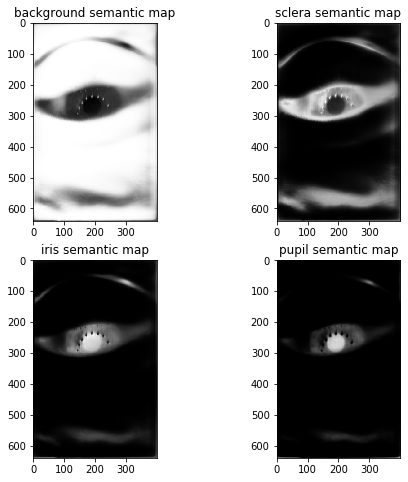

In [13]:
fig = plt.figure(figsize=(8, 8))

sub1 = plt.subplot(2, 2, 1)
sub1.set_title('background semantic map')
sub1.imshow(pred[0, :, :, 0], cmap='gray')

sub2 = plt.subplot(2, 2, 2)
sub2.set_title('sclera semantic map')
sub2.imshow(pred[0, :, :, 1], cmap='gray')

sub3 = plt.subplot(2, 2, 3)
sub3.set_title('iris semantic map')
sub3.imshow(pred[0, :, :, 2], cmap='gray')

sub4 = plt.subplot(2, 2, 4)
sub4.set_title('pupil semantic map')
sub4.imshow(pred[0, :, :, 3], cmap='gray')

plt.show()

## Mapa Semántico procesado

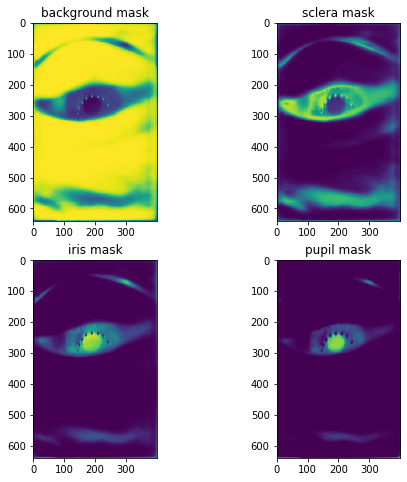

In [14]:
fig = plt.figure(figsize=(8, 8))

sub1 = plt.subplot(2, 2, 1)
sub1.set_title('background mask')
sub1.imshow((pred[0, :, :, 0]*255).astype(np.uint8))

sub2 = plt.subplot(2, 2, 2)
sub2.set_title('sclera mask')
sub2.imshow((pred[0, :, :, 1]*255).astype(np.uint8))

sub3 = plt.subplot(2, 2, 3)
sub3.set_title('iris mask')
sub3.imshow((pred[0, :, :, 2]*255).astype(np.uint8))

sub4 = plt.subplot(2, 2, 4)
sub4.set_title('pupil mask')
sub4.imshow((pred[0, :, :, 3]*255).astype(np.uint8))

plt.show()

In [15]:
np.unique((pred[0, :, :, :]*255).astype(np.uint8)) 
# deberiamos obtener algo cercano a array([  0, 255], dtype=uint8)
# o pocos valores entre [0, 255]
# ej: [0, 10, 15, 210, 255]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

## Reverse One-Hot & Colour Code Segmentation

shape: (640, 400, 3)
dtype: uint8


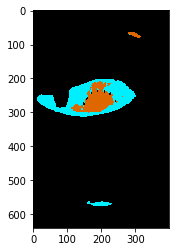

In [16]:
im_pred = helpers.reverse_one_hot(pred[0])
im_pred = helpers.colour_code_segmentation(im_pred, dp.label_values)
print('shape:', im_pred.shape)
print('dtype:', im_pred.dtype)
plt.imshow(im_pred)
plt.show()

## Colores e indices de la imagen de arriba?

In [17]:
colors_code, indexes = np.unique(im_pred, return_index=True)
print('colors_code:', colors_code)
print('indexes:', indexes)

colors_code: [  0 103 223 239 255]
indexes: [    0 77644 77643 84823 84824]


In [18]:
plt.imsave('unet_model_predict.png', im_pred)